<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/FINAL%20_FILES/MNIST_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import data and write all classes and functions used for training

**Import libraries used**

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
tf.autograph.set_verbosity(0)

**Import MNIST dataset and write plotting function**

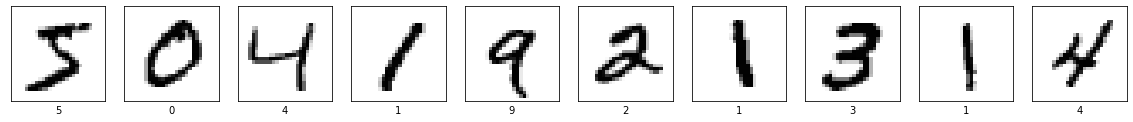

In [89]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

def plot_images(x_train, y_train, figures_to_plot, pick_random=False, include_labels=True):
    n_rows = np.ceil((figures_to_plot[1])/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot[0],figures_to_plot[1]):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

plot_images(x_train, y_train, [0,10])

**Function to create a TensorFlow Dataset.**

pick_class = returns all the MNIST data (images and labels) of the classes selected in the argument

set_pixels_binary = scale all the pixels in a range of 0 to 1

cut_data = returns a subsection of the data (up to a certain number given as an argument)

In [0]:
def pick_class(x, y, class_n):
    pics = (y == class_n[0])
    for i in range(len(class_n)-1):
      pics = pics + (y == class_n[i+1])
    new_x = x[pics]
    new_y = y[pics]
    return new_x, new_y

def set_pixels_binary(images):
    images = images/input_range
    return images

def cut_data(data, data_number):
    data = data[0:data_number]
    return data

def setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9], data_number = -1):
  x_train, y_train = pick_class(x_train, y_train, chosen_classes)
  x_test, y_test = pick_class(x_test, y_test, chosen_classes)
  
  x_train = cut_data(x_train, data_number)
  y_train = cut_data(y_train, data_number)

  x_train = set_pixels_binary(x_train)
  x_test = set_pixels_binary(x_test)

  x_train = x_train.reshape(len(y_train), image_shape[0], image_shape[1], N_image_channels).astype('float32')
  x_test = x_test.reshape(len(y_test), image_shape[0], image_shape[1], N_image_channels).astype('float32')

  batch_size = 100
  train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(len(y_train)).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices(x_test).shuffle(len(y_test)).batch(batch_size)
  return x_train, y_train, x_test, y_test, train_dataset, test_dataset

**Class of the Variational Autoencoder Models (VAE and Concolutional VAE)**

encode = takes an image and returns the mean and the log(variance) of its latent vector 

reparameterize = takes the mean and log(variance) of a latent vector and samples a vector from them

decode = takes a latent vector and returns the logits of the output (these will have to be passed through a sigmoid function to obtain the reconstruction of x)

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(500, activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Dense(200, activation='relu'),
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(200, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Dense(500, activation='relu'),
                          tf.keras.layers.Dense(28*28*1),
                          tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
                          ])

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      

    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        return pixel_output

In [0]:
class CVAE_convolutional(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE_convolutional, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Conv2D(32, (3,3), strides = (2,2), activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(64, (3,3), strides = (2,2), activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(units=7*7*64, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
                          tf.keras.layers.Conv2DTranspose(32, (3,3), strides = (2,2), activation='relu', padding='SAME'),
                          tf.keras.layers.Conv2DTranspose(1, (3,3), strides = (2,2), padding='SAME'),
                          ])

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      

    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        return pixel_output

**Function to compute the ELBO loss**

Takes an image and returns the ELBO loss. The term variance is a hyperparameter and can be changed

In [0]:
def calculate_ELBO(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  pixel_prob = tf.math.sigmoid(x_logit)

  variance = 0.2**2
  logpx_z = tf.reduce_sum(-.5 * (((x - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
  KL = -0.5*(tf.reduce_sum(tf.math.add(logvar,1), axis=1) - tf.reduce_sum(tf.exp(logvar), axis=1) - tf.reduce_sum(tf.exp(mean ** 2), axis=1))

  return -tf.reduce_mean(logpx_z - KL)

**Define optimizer and loss metrics**

The learnign rate of the Adam optimizer is a hyperparameter

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

**Define a function for a train and test step**

train_step = updated the model using the optimizer and the gradients of the loss function; updates the train_loss metric

test_step = calculates the loss function of the test image; updates the test_loss metric

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x):
    loss = calculate_ELBO(model, x)
    test_loss(loss)

**Write function to train the dataset**

takes train and test datasets and trains the train dataset for a number of epochs

plots the ELBO value of the train and test dataset for each epoch

generates images obtained from a random latent vector (sampled form a normal distribution)

In [0]:
def generate_images(model, z_random, figures_to_plot):
    generated_prob = model.decode(z_random)
    generated_prob = tf.math.sigmoid(generated_prob)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot, include_labels=False)

In [0]:
def train_test_dataset(model, train_dataset, test_dataset, epochs, generate=True):
  plots_per_epoch = 10
  z_random = tf.random.normal(shape=[plots_per_epoch, z_size])
  
  test_ELBO = []
  train_ELBO = []
  epoch_number = []  
  for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for train_x in train_dataset: 
      train_step(model, train_x, optimizer)
  
    for test_x in test_dataset:
      test_step(model, test_x)
    
    test_ELBO.append(-test_loss.result())
    train_ELBO.append(-train_loss.result())
    epoch_number.append(epoch)
    
    clear_output()
    if generate:
      generate_images(model, z_random, [0,plots_per_epoch])
    plt.plot(epoch_number, test_ELBO, train_ELBO)
    plt.legend(['test','train'])
    plt.title('model')
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()

#### Train

**Change the amount of data from each class (if desired)**

In [0]:
def change_ratio(x, y, chosen_classes, chosen_numbers):
    x_new = np.zeros([0,image_shape[0], image_shape[1]])
    y_new = np.zeros([0])
    n_classes = len(chosen_classes)
    for i in range (n_classes):
        if chosen_classes[i] != -1:
            x_class, y_class = pick_class(x, y, [chosen_classes[i]])
            x_class = cut_data(x_class, chosen_numbers[i])
        y_class = cut_data(y_class, chosen_numbers[i])
        x_new = np.concatenate((x_new, x_class))
        y_new = np.concatenate((y_new, y_class))
    return x_new, y_new

chosen_classes=[0,1,2,3,4,5,6,7,8,9]
chosen_numbers = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
x_train, y_train = change_ratio(x_train, y_train, chosen_classes, chosen_numbers)
chosen_numbers = [850, 850, 850, 850, 850, 850, 850, 850, 850, 850]
x_test, y_test = change_ratio(x_test, y_test, chosen_classes, chosen_numbers)

**Train 1 VAE with all the classes**

select the size of the latent space and the epochs of training for each model

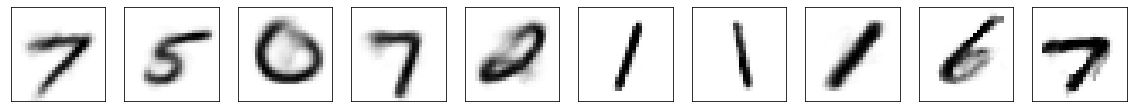

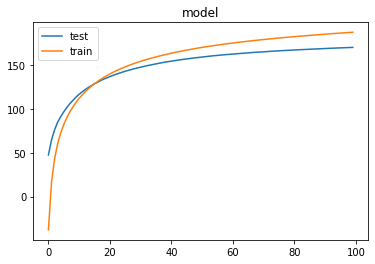

In [16]:
train_images, train_labels, test_images, test_labels, train_dataset, test_dataset = setup_dataset(x_train, y_train, x_test, y_test)
z_size = 2
model = CVAE(z_size)
train_test_dataset(model, train_dataset, test_dataset, 100, generate=True)

**Check reconstruction performance**

Select a range of image to reconstruct, the ELBO loss is displayed under each reconstruction

Original Pictures:


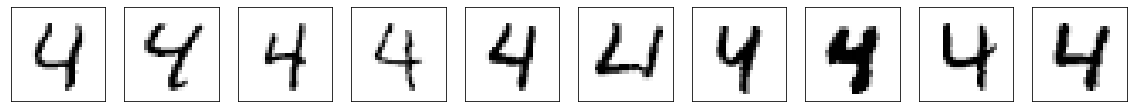

Reconstructed Pictures with VAE:


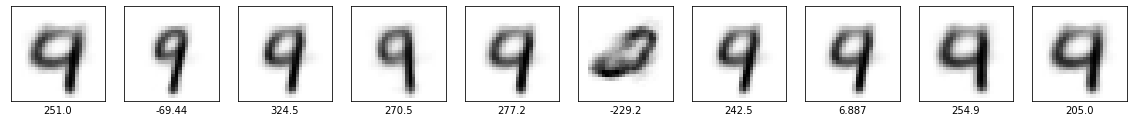

In [20]:
def reconstruct_images(model, images):
    images_n = len(images)
    x = images

    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i] = calculate_ELBO(model,x[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(images[:,:,:,0], _, figures_to_plot=[0,images_n], include_labels=False)
    print('Reconstructed Pictures with VAE:')
    plot_images(pixel_prob, -loss, figures_to_plot=[0,images_n], include_labels=True)

reconstruct_images(model, test_images[4*850:4*850+10])

**Visualize the latent space**

select a range (range1 to range2) of the train/test data for which to plot the latent vector values of 2 dimensions (a and b)

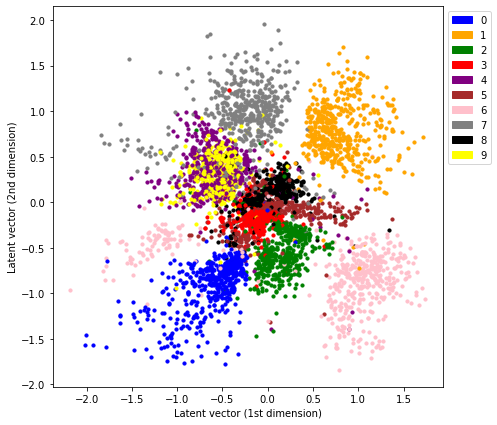

In [30]:
import matplotlib.patches as mpatches
import sklearn.utils
def visualize_latent_space(model, range1, range2, data_x, data_y, a, b):
  plot = plt.figure(figsize=[7,7])
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize.reshape(1, 28, 28, 1).astype('float32')
    label_visualize = np.zeros([10,])
    label_visualize[int(data_y[i])] = 1
    label_visualize = label_visualize.reshape(1, len(label_visualize))
    
    z_mean, z_logvar = model.encode(pic_visualize)
    z = model.reparameterize(z_mean, z_logvar)
    num=np.argmax(label_visualize)

    if num == 0:
      color = 'blue'
    if num == 1:
      color = 'orange'
    if num == 2:
      color = 'green'
    if num == 3:
      color = 'red'
    if num == 4:
      color = 'purple'  
    if num == 5:
      color = 'brown'
    if num == 6:
      color = 'pink'
    if num == 7:
      color = 'gray'
    if num == 8:
      color = 'black'
    if num == 9:
      color = 'yellow'
    plt.scatter(z[:,a],z[:,b], color=color, s=10)
  plt.xlabel('Latent vector (1st dimension)')
  plt.ylabel('Latent vector (2nd dimension)')
  blue = mpatches.Patch(color = 'blue', label='0')
  orange = mpatches.Patch(color = 'orange', label='1')
  green = mpatches.Patch(color = 'green', label='2')
  red = mpatches.Patch(color = 'red', label='3')
  purple = mpatches.Patch(color = 'purple', label='4')
  brown = mpatches.Patch(color = 'brown', label='5')
  pink = mpatches.Patch(color = 'pink', label='6')
  gray = mpatches.Patch(color = 'gray', label='7')
  black = mpatches.Patch(color = 'black', label='8')
  yellow = mpatches.Patch(color = 'yellow', label='9')
  plt.legend(handles=[blue, orange, green, red, purple, brown, pink, gray, black, yellow], bbox_to_anchor=(1,1), loc='upper left')

test_images_shuffled, test_labels_shuffled = sklearn.utils.shuffle(test_images, test_labels)
visualize_latent_space(model, 0,5000, test_images_shuffled, test_labels_shuffled, 0,1)